In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from patsy import bs
import cv2
%matplotlib inline

In [37]:
def load_mnist(num_training=55000, num_validation=5000, num_test=10000):

    # Load the raw mnist dataset and use appropriate data types and shapes
    mnist = tf.keras.datasets.mnist.load_data()
    (X_train, y_train), (X_test, y_test) = mnist
    X_train = np.asarray(X_train, dtype=np.float32)
    y_train = np.asarray(y_train, dtype=np.int32).flatten()
    X_test = np.asarray(X_test, dtype=np.float32)
    y_test = np.asarray(y_test, dtype=np.int32).flatten()

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    # Normalize the data: be in 0-1
    X_train = X_train / 255
    X_val = X_val / 255
    X_test = X_test / 255

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
NHW = (0, 1, 2)
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (55000, 28, 28)
Train labels shape:  (55000,) int32
Validation data shape:  (5000, 28, 28)
Validation labels shape:  (5000,)
Test data shape:  (10000, 28, 28)
Test labels shape:  (10000,)


1.0


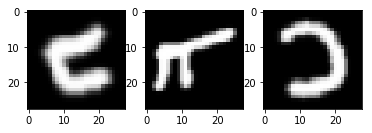

In [32]:
letter_data = np.load("letter_data.npy")
mask = range(7000, 10000)
letter_val = letter_data[mask]
mask = range(7000)
letter_train = letter_data[mask]

IMG_SIZE = 28
IMG_SHAPE = (IMG_SIZE,IMG_SIZE,1)
K = IMG_SIZE*IMG_SIZE/16
def format_images(images):
    res = np.zeros([images.shape[0], IMG_SIZE, IMG_SIZE])
    for i in range(images.shape[0]):
        res[i,:,:] = cv2.resize(images[i,:,:], (IMG_SIZE, IMG_SIZE))
        res[i,:,:] /= np.max(res[i,:,:])
    res = np.reshape(res,[-1,IMG_SIZE,IMG_SIZE,1])
    return np.asarray(res,dtype=np.float32)

show = format_images(letter_data[:10,:,:])
print(np.max(show[0,:,:,0]))
plt.figure(1)
plt.subplot(131)
plt.imshow(show[1,:,:,0], cmap='gray')
plt.subplot(132)
plt.imshow(show[5,:,:,0], cmap='gray')
plt.subplot(133)
plt.imshow(show[7,:,:,0], cmap='gray')
plt.show()

In [33]:
def show_img(fig, images, kimgs, loc, xpo, ypo):
    plt.figure(fig)
    for i in range(3):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i,:,:], cmap='gray')
    for i in range(3):
        plt.subplot(3,3,i+4)
        plt.imshow(kimgs[i,:,:], cmap='gray')
    for i in range(3):
        plt.subplot(3,3,i+7)
        xi = xpo[i,:]; yi = ypo[i,:]; t = len(xi)
        loci = loc[i,:,:]; n = loci.shape[0]
        s = np.linspace(25, 5, num=n)
        plt.plot(yi, -xi)
        plt.scatter(loci[:,1], -loci[:,0], s=s)
        plt.xlim(0,1); plt.ylim(-1,0)
    return

In [41]:
def reconstruction_xy(loc, moment, section=3, num_points=30):
    """Using position and moments to reconstruct points on curve"""
    M = tf.constant([[1,0,0,0],[1,1,1,1],[0,1,0,0],[0,1,2,3]], dtype=tf.float32)
    M = tf.transpose(tf.linalg.inv(M))
    t_value = np.linspace(0,1, num = section+1)
    tpoints = np.linspace(0, 1, num=num_points)
    basis = np.vstack([tpoints**0, tpoints**1, tpoints**2, tpoints**3])
    basis = tf.constant(basis, dtype=tf.float32)

    i = 0
    x_i = tf.gather(loc, [i,i+1], axis=1)
    m_i = tf.gather(moment, [i,i+1], axis=1)
    xm_i = tf.concat([x_i, m_i], 1)
    coeff = tf.matmul(xm_i, M)
    curve = tf.matmul(coeff, basis)
    ### consequent intervals
    for i in range(1, section):
        x_i = tf.gather(loc, [i,i+1], axis=1)
        m_i = tf.gather(moment, [i,i+1], axis=1)
        xm_i = tf.concat([x_i, m_i], 1)
        coeff_i = tf.matmul(xm_i, M)
        curve_i = tf.matmul(coeff_i, basis)
        coeff = tf.concat([coeff, coeff_i], 1)
        curve = tf.concat([curve, curve_i], 1)
    return curve, coeff

def reconstruction(loc, moment, section=3, num_points=30):
    x_points, x_coeff = reconstruction_xy(loc[:,:,0], moment[:,:,0], section, num_points)
    y_points, y_coeff = reconstruction_xy(loc[:,:,1], moment[:,:,1], section, num_points)
    return x_points, y_points, x_coeff, y_coeff

def kernel_image(x_points, y_points, sig2):
    index_tensor = np.zeros([IMG_SIZE,IMG_SIZE,2], dtype=np.float32)
    for i in range(IMG_SIZE):
        for j in range(IMG_SIZE):
            index_tensor[i,j,:] = [i/(IMG_SIZE-1.0), j/(IMG_SIZE-1.0)]
    locations = tf.constant(index_tensor)
    points = tf.stack([x_points, y_points], axis=2)
    dist = tf.einsum("iju,ntu->nijt", locations**2, tf.ones_like(points)) -\
           2 * tf.einsum("iju,ntu->nijt", locations, points) +\
           tf.einsum("iju,ntu->nijt", tf.ones_like(locations), points**2)
    kernel = tf.exp(-0.5*tf.einsum("nijt,n->nijt", dist, sig2**(-1)))
    images = tf.reduce_sum(kernel, axis=3)
    images = tf.tanh(images)
    return images

def loss(images, kernel_img):
    return tf.reduce_mean((images-kernel_img)**2)

1.0


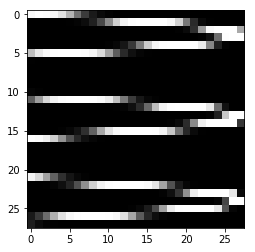

In [42]:
xpo = np.linspace(0,1,num=3000, dtype=np.float32)
ypo = np.sin(16*xpo, dtype=np.float32)
sig2 = np.array([0.00005],dtype=np.float32)
xx = kernel_image(tf.constant(np.reshape(xpo,[1,-1])), 
                  tf.constant(np.reshape(ypo,[1,-1])),
                  tf.constant(sig2))
print(np.max(xx.numpy()))
plt.imshow(xx.numpy()[0,:,:], cmap="gray")
plt.show()

In [43]:
def coding_net(num_filter=32, section=3, lam=1e-3):   
    reg = keras.regularizers.l2(l=lam)
#     init = keras.initializers.RandomNormal(stddev=std)
    inputs = keras.Input(shape=IMG_SHAPE, name="input_image")
    # First Convolution layers
    conv1 = layers.Conv2D(filters=num_filter,
                          kernel_size=[5,5],
                          padding="same",
                          kernel_regularizer=reg,
                          activation=tf.nn.relu6)(inputs)
    batch1 = layers.BatchNormalization()(conv1)
    pool1 = layers.MaxPool2D(pool_size=[2,2],strides=2)(batch1)
    dropout1 = layers.Dropout(0.9)(pool1)
    # Second Convolution layers
    conv2 = layers.Conv2D(filters=num_filter*2,
                          kernel_size=[5,5],
                          padding="same",
                          kernel_regularizer=reg,
                          activation=tf.nn.relu6)(dropout1)
    batch2 = layers.BatchNormalization()(conv2)
    pool2 = layers.MaxPool2D(pool_size=[2,2],strides=2)(batch2)
    dropout2 = layers.Dropout(0.7)(pool2)
    
    drop2_flat = tf.reshape(dropout2, [-1, int(IMG_SIZE*IMG_SIZE*num_filter/8)])
    dense = layers.Dense(1024, activation=tf.nn.relu,
                         kernel_regularizer=reg)(drop2_flat)
    dropout3 = layers.Dropout(0.5)(dense)
    
    loc = layers.Dense((section+1)*2, 
                        activation = tf.nn.sigmoid,
                        kernel_regularizer=reg)(dropout3)
    moment = layers.Dense((section+1)*2, 
                          kernel_regularizer=reg)(dropout3)
    sig2 = layers.Dense(1,kernel_regularizer=reg)(dropout3)**2
    outputs = tf.concat([loc,moment,sig2],axis=1)
    return keras.Model(inputs=inputs,outputs=outputs,name="coding_net")

def decode(outputs, section, num_points):
    loc = tf.reshape(outputs[:,:((section+1)*2)], [-1, section+1, 2])
    moment = tf.reshape(outputs[:,((section+1)*2):-1], [-1, section+1, 2])
    sig2 = tf.reshape(outputs[:,-1], (-1,))
    xp,yp,xcoeff,ycoeff = reconstruction(loc,moment,section,num_points)
    kernel_imgs = kernel_image(xp,yp,sig2=sig2)
    return kernel_imgs,(xp,yp),(loc,moment,sig2),(xcoeff,ycoeff)

def total_loss(section,nump,lambs):
    def resloss(Images,outputs):
        kernel_imgs,xy,para,_= decode(outputs,section, nump)
        x_points,y_points = xy
        loc,moment,sig2 = para
        lam_sep = lambs[0]; lam_len = lambs[1]; lam_smooth = lambs[2]
        lam_sig = lambs[-1]
        totalp = section*nump
        total_loss = loss(kernel_imgs,Images)
        
        xdiff = x_points[:,1:totalp] - x_points[:,:(totalp-1)]
        ydiff = y_points[:,1:totalp] - y_points[:,:(totalp-1)]
        loc_xdiff = loc[:,1:(section+1),0] - loc[:,:section,0]
        loc_ydiff = loc[:,1:(section+1),1] - loc[:,:section,1]

        eps = 1e-8
        length_penalty = tf.reduce_mean(
                            tf.reduce_sum(
                                tf.sqrt(
                                    tf.clip_by_value(xdiff**2 + ydiff**2, eps, 1)
                                ),
                                axis = 1
                            )
                         )
        sep_penalty = -tf.reduce_mean(
                            tf.reduce_sum(
                                tf.sqrt(loc_xdiff**2 + loc_ydiff**2),
                                axis = 1
                            )
                         )
        smooth_penalty = tf.reduce_mean((
                            moment[:,1:(section+1),:] - moment[:,:section,:]
                         )**2)
        sig2_penalty = tf.reduce_mean(sig2)
        
        return total_loss +\
               lam_len*length_penalty +\
               lam_sep*sep_penalty + lam_smooth*smooth_penalty +\
               lam_sig*sig2_penalty
    return resloss

Model: "coding_net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   832         input_image[0][0]                
__________________________________________________________________________________________________
batch_normalization_v2 (BatchNo (None, 28, 28, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 14, 14, 32)   0           batch_normalization_v2[0][0]     
_________________________________________________________________________________________

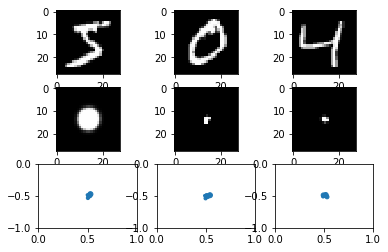

In [55]:
tf.compat.v1.reset_default_graph()
keras.backend.clear_session()
try:
    del model
except:
    pass

num_filter = 32; std = 0.5
section = 4; num_points = 20; lam = 1e-3
lam_sep = 1e-4; lam_len = 1e-3; lam_smooth = 1e-3
lam_sig = 5e-2
learning_rate = 1e-4
model = coding_net(num_filter, section, lam)
model_loss = total_loss(section,num_points,[lam_sep,lam_len,lam_smooth,lam_sig])
optimizer = tf.optimizers.Adam(learning_rate)
model.compile(optimizer=optimizer, loss=model_loss)
model.summary()

train = format_images(X_train[:3,:,:])
outputs = model.predict(train)
kimg,xy,para,_ = decode(outputs,section,num_points)
xpo,ypo = xy
loc,_,_ = para
print(model_loss(train[:,:,:,0], outputs))
print(loc[0,:,0])
print(loc[0,:,1])
show_img(1,train[:,:,:,0], kimg,loc,xpo,ypo)
plt.show()

tf.Tensor(0.34873068, shape=(), dtype=float32)
tf.Tensor([0.50847673 0.59718674 0.4305674  0.45700866], shape=(4,), dtype=float32)


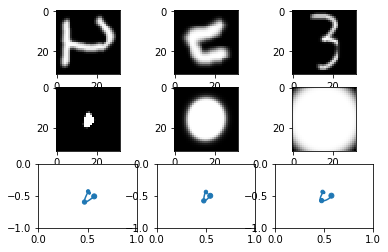

In [137]:
train = format_images(letter_data[:3,:,:])
model.train_on_batch(train,train[:,:,:,0])
outputs = model.predict(train)
kimg,xy,para,_ = decode(outputs,section,num_points)
xpo,ypo = xy
loc,_,_ = para
print(model_loss(train[:,:,:,0], outputs))
print(loc[0,:,0])
show_img(1,train[:,:,:,0], kimg,loc,xpo,ypo)
plt.show()

Training
Sigma2: 1.0765e-06  Sigma2: 0.0012624  Sigma2: 1.1167e-05
tf.Tensor([0.4892624  0.50427616 0.51183337 0.5183401  0.48121473], shape=(5,), dtype=float32)
tf.Tensor([0.5267207  0.5049648  0.527125   0.5025816  0.50131255], shape=(5,), dtype=float32)


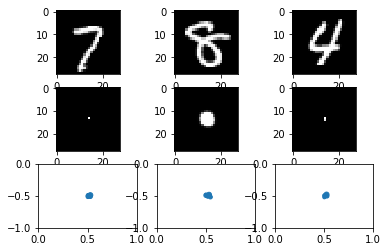

Sigma2: 5.1153  Sigma2: 5.8391  Sigma2: 4.4952
tf.Tensor([0.66966164 0.156903   0.47028258 0.95337003 0.28663176], shape=(5,), dtype=float32)
tf.Tensor([0.8742529  0.5795157  0.61733776 0.4950436  0.2642231 ], shape=(5,), dtype=float32)


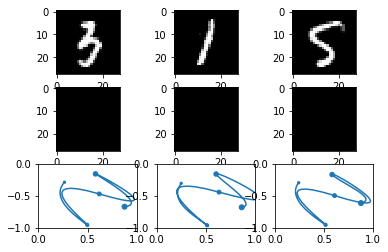

Sigma2: 0.84271  Sigma2: 0.78284  Sigma2: 0.58582
tf.Tensor([0.0786154  0.02188843 0.05026603 0.6795471  0.03879139], shape=(5,), dtype=float32)
tf.Tensor([0.9795238  0.9383985  0.85246897 0.8853845  0.81466585], shape=(5,), dtype=float32)


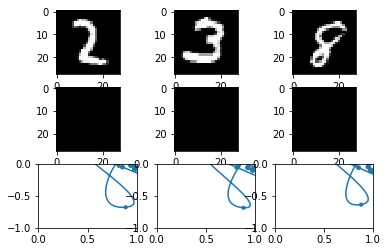

Sigma2: 4.4198  Sigma2: 1.2755  Sigma2: 0.42713
tf.Tensor([0.01290888 0.0023281  0.00457674 0.28188902 0.00666434], shape=(5,), dtype=float32)
tf.Tensor([0.99552524 0.9881538  0.99371123 0.98806083 0.9776353 ], shape=(5,), dtype=float32)


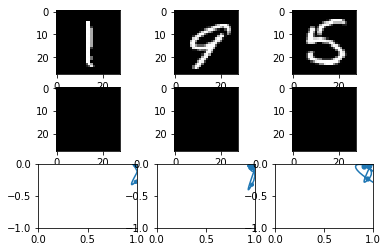

Sigma2: 0.020271  Sigma2: 0.0076293  Sigma2: 0.069523
tf.Tensor([0.0517247  0.04810941 0.1251713  0.14489168 0.04392889], shape=(5,), dtype=float32)
tf.Tensor([0.9530516 0.9274684 0.9693238 0.9650171 0.8765813], shape=(5,), dtype=float32)


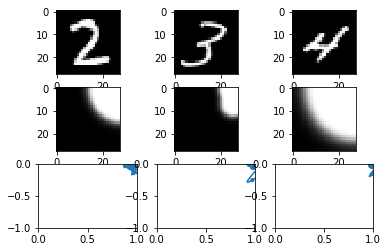

Sigma2: 0.028991  Sigma2: 0.085737  Sigma2: 0.064713
tf.Tensor([0.01013613 0.00535807 0.01044771 0.08838639 0.01231369], shape=(5,), dtype=float32)
tf.Tensor([0.9895311  0.9875139  0.98978555 0.9939532  0.9792658 ], shape=(5,), dtype=float32)


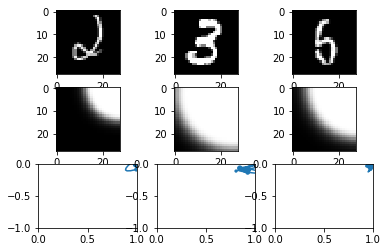

Sigma2: nan  Sigma2: nan  Sigma2: nan
tf.Tensor([1. 1. 1. 1. 1.], shape=(5,), dtype=float32)
tf.Tensor([1. 1. 1. 1. 1.], shape=(5,), dtype=float32)


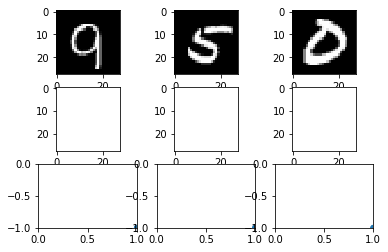

KeyboardInterrupt: 

In [56]:
def run_model(model, Xd, Xval,
              epochs=5, batch_size=64, print_every=100):

    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)    
    
    iter_cnt = 0
    fig = 1
    for e in range(epochs):
        losses = []
        val_losses = []
        for i in range(int(np.ceil(Xd.shape[0]/batch_size))):
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            Images = format_images(Xd[idx,:,:])
            model.train_on_batch(Images,Images[:,:,:,0])

            if (iter_cnt % print_every) == 0:
                ### show img
                val_ind = np.random.randint(0,Xval.shape[0],size=3)
                
                img_val = format_images(Xval[val_ind,:,:])
                
                outputs = model.predict(img_val)
                kimg,xy,para,_ = decode(outputs, section,num_points)
                xpo,ypo= xy
                loc,moment,sig2 = para
                print("Sigma2: {0:.5g}  Sigma2: {1:.5g}  Sigma2: {2:.5g}"\
                      .format(sig2[0],sig2[1],sig2[2]))
                print(loc[0,:,0])
                print(loc[0,:,1])
                show_img(fig, img_val[:,:,:,0], kimg,loc,xpo,ypo)
                fig += 1
                plt.show()
                
            iter_cnt += 1
    return

with tf.device("/gpu:0"):
    print('Training')
    run_model(model,X_train,X_val,5,64,200)